## Reading Data from HDFS

Datasource: Semantic Scholar Open Research Corpus

Description: Semantic Scholar's records for research papers published in all fields provided as an easy-to-use JSON archive.

### Attribute Definitions
1. id  string = S2 generated research paper ID.
- title  string = Research paper title.
- paperAbstract  string = Extracted abstract of the paper.
- entities  list = Extracted list of relevant entities or topics.
- s2Url  string = URL to S2 research paper details page.
- s2PdfUrl  string = URL to PDF on S2 if available.
- pdfUrls  list = URLs related to this PDF scraped from the web.
- authors  list = List of authors with an S2 generated author ID and name.
- inCitations  list = List of S2 paper IDs which cited this paper.
- outCitations  list = List of S2 paper IDs which this paper cited
- year  int = Year this paper was published as integer.
- venue  string = Extracted publication venue for this paper.
- journalName  string = Name of the journal that published this paper.
- journalVolume  string = The volume of the journal where this paper was published.
- journalPages  string = The pages of the journal where this paper was published.
- sources  list = Identifies papers sourced from DBLP or Medline.
- doi  string = Digital Object Identifier registered at doi.org.
- doiUrl  string = DOI link for registered objects.
- pmid  string = Unique identifier used by PubMed.
- fieldsOfStudy  list = Zero or more fields of study this paper addresses.`

In [1]:
import pandas as pd 
import json
import matplotlib.pyplot as plt 

In [2]:
#import statements
from pyspark.sql import SparkSession

spark = SparkSession.builder.enableHiveSupport().appName('ReadWriteData').getOrCreate()
sc = spark.sparkContext

In [2]:
sc.environment

{'MKL_NUM_THREADS': '1', 'OPENBLAS_NUM_THREADS': '1', 'PYTHONHASHSEED': '0'}

In [3]:
spark_df = spark.read.json('big_data_project/s2-corpus-000.txt')
spark_df2 = spark.read.json('big_data_project/s2-corpus-001.txt')

In [4]:
spark_df.printSchema()

root
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ids: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- doiUrl: string (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fieldsOfStudy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- inCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- journalName: string (nullable = true)
 |-- journalPages: string (nullable = true)
 |-- journalVolume: string (nullable = true)
 |-- outCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- paperAbstract: string (nullable = true)
 |-- pdfUrls: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pmid: string (nullable = t

In [5]:
spark_df2.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ids: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- doiUrl: string (nullable = true)
 |-- entities: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fieldsOfStudy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- inCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- journalName: string (nullable = true)
 |-- journalPages: string (nullable = true)
 |-- journalVolume: string (nullable = true)
 |-- outCitations: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- paperAbstract: string (nullable = true)
 |-- pdfUrls: array (nullable = true)
 |    |-- element: string (conta

In [8]:
spark_df2.count()

5955151

In [9]:
spark_df2 = spark_df2.drop("_corrupt_record")

## Checking that columns & datatypes are equal for both files

In [10]:
print('Are the # of columns equal? ==>', len(spark_df2.columns) == len(spark_df.columns))

print('Are the dtypes of columns equal? ==>', (spark_df2.dtypes) == (spark_df.dtypes))

Are the # of columns equal? ==> True
Are the dtypes of columns equal? ==> True


In [11]:
print('Total number of rows expected after union = ',spark_df.count() + spark_df2.count())

Total number of rows expected after union =  6955022


## Join the dfs 

In [12]:
spark_df3 = spark_df.union(spark_df2)

In [13]:
spark_df3.count()

6955022

In [14]:
spark_df3.dropna().count()

6820367

In [52]:
spark_df3.select('fieldsOfStudy').distinct().count()

1831

In [53]:
spark_df3.groupby('fieldsOfStudy').count().sort("count").orderBy(["count"], ascending=[0]).show(20)

+--------------------+-------+
|       fieldsOfStudy|  count|
+--------------------+-------+
|          [Medicine]|1266282|
|                  []| 907093|
|         [Chemistry]| 468369|
|  [Computer Science]| 429008|
|       [Engineering]| 378788|
|           [Biology]| 345616|
|           [Physics]| 325009|
| [Materials Science]| 262046|
| [Biology, Medicine]| 234569|
|           [History]| 229989|
|        [Psychology]| 216940|
|               [Art]| 206989|
|       [Mathematics]| 189919|
| [Political Science]| 189145|
|         [Sociology]| 174594|
|         [Geography]| 173749|
|         [Economics]| 142621|
|          [Business]| 135709|
|           [Geology]| 117060|
|[Chemistry, Medic...| 114251|
+--------------------+-------+
only showing top 20 rows



In [54]:
spark_df3.select('year').distinct().count()

86

## Creating column that counts the inCitations

In [15]:
from pyspark.sql.functions import udf #user defined function
from pyspark.sql.types import * #Import types == IntegerType, StringType etc.

length = udf(lambda listt: len(listt), IntegerType())

In [16]:
spark_df3 = spark_df3.withColumn('inCitations_count', length(spark_df3['inCitations']))

In [17]:
spark_df3.select('inCitations_count', 'inCitations').show(10)

+-----------------+--------------------+
|inCitations_count|         inCitations|
+-----------------+--------------------+
|                6|[de4369814785d2f3...|
|                0|                  []|
|                0|                  []|
|               30|[ab5c10646896d921...|
|                0|                  []|
|                0|                  []|
|                0|                  []|
|                0|                  []|
|              129|[c4e7a25f671de435...|
|                6|[defe6d4c1d146183...|
+-----------------+--------------------+
only showing top 10 rows



## Creating column that for length of abstract

In [19]:
spark_df3.select('paperAbstract').show(1)

+--------------------+
|       paperAbstract|
+--------------------+
|The main objectiv...|
+--------------------+
only showing top 1 row



In [35]:
# # Construction 2
# from spacy.lang.en import English
# nlp = English()
# # Create a Tokenizer with the default settings for English
# # including punctuation rules and exceptions
# tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [36]:
import nltk

In [37]:
word_count = udf(lambda string: len(nltk.word_tokenize(string)), IntegerType())

spark_df3 = spark_df3.withColumn('paperAbstract_wcount', word_count(spark_df3['paperAbstract']))

In [39]:
spark_df3.select('paperAbstract_wcount', 'paperAbstract').show(10)

+--------------------+--------------------+
|paperAbstract_wcount|       paperAbstract|
+--------------------+--------------------+
|                 405|The main objectiv...|
|                  57|This article refl...|
|                 183|In this work, kee...|
|                  29|Resumen pt: O obj...|
|                 192|The Financial sec...|
|                   0|                    |
|                   0|                    |
|                   0|                    |
|                 142|The progress in m...|
|                 159|Abstract This stu...|
+--------------------+--------------------+
only showing top 10 rows



In [41]:
spark_df3 = spark_df3.withColumn('title_wcount', word_count(spark_df3['title']))
spark_df3.select('title_wcount', 'title').show(10)

+------------+-------------------------------------+
|title_wcount|                                title|
+------------+-------------------------------------+
|          19|                 Relationship betw...|
|          15|                 Aplicación y crít...|
|          11|                 On decomposition ...|
|          11|                 Reflexões Sobre O...|
|           3|                 Banking Sector Re...|
|          18|                 [identification, ...|
|           9|                 SARS control: Fir...|
|           2|日本語教育における助数詞の扱いの問...|
|          10|                 Continuous separa...|
|          13|                 Aqueous phase ref...|
+------------+-------------------------------------+
only showing top 10 rows



## Fixing some dtypes


In [43]:
#Convert the list + string into string
spark_df4 = spark_df3.withColumn("authors", spark_df3["authors"].cast(StringType()))
spark_df4 = spark_df4.withColumn("entities", spark_df4["entities"].cast(StringType()))
spark_df4 = spark_df4.withColumn("fieldsOfStudy", spark_df4["fieldsOfStudy"].cast(StringType()))
spark_df4 = spark_df4.withColumn("inCitations", spark_df4["inCitations"].cast(StringType()))
spark_df4 = spark_df4.withColumn("outCitations", spark_df4["outCitations"].cast(StringType()))
spark_df4 = spark_df4.withColumn("pdfUrls", spark_df4["pdfUrls"].cast(StringType()))
spark_df4 = spark_df4.withColumn("sources", spark_df4["sources"].cast(StringType()))

In [44]:
from pyspark.sql import functions as F

#split authors into authors/id into multiple columns 
split_col = F.split(spark_df4['authors'], ',')

spark_df4 = spark_df4.withColumn('ID', split_col.getItem(0))
spark_df4 = spark_df4.withColumn('authors', split_col.getItem(1))

In [45]:
spark_df4.select('authors', 'ID').show(10)

+--------------------+-------------+
|             authors|           ID|
+--------------------+-------------+
|     Frederik Accoe]| [[[11348185]|
| Enrique Cuna Pér...| [[[50657823]|
|          N. Shiiba]| [[[14019388]|
| Ariane Fazzolo S...| [[[14573970]|
| Obida Gobna Wafu...|[[[119356007]|
|         A. Pittera]| [[[11465179]|
|       Carrie Lock]]|[[[145371798]|
|         幸子 北川]]|[[[135803841]|
|    Andreas Lenshof]|  [[[3435821]|
|    Toshiaki Nozawa]| [[[92141798]|
+--------------------+-------------+
only showing top 10 rows



In [46]:
spark_df4.dtypes

[('authors', 'string'),
 ('doi', 'string'),
 ('doiUrl', 'string'),
 ('entities', 'string'),
 ('fieldsOfStudy', 'string'),
 ('ID', 'string'),
 ('inCitations', 'string'),
 ('journalName', 'string'),
 ('journalPages', 'string'),
 ('journalVolume', 'string'),
 ('outCitations', 'string'),
 ('paperAbstract', 'string'),
 ('pdfUrls', 'string'),
 ('pmid', 'string'),
 ('s2PdfUrl', 'string'),
 ('s2Url', 'string'),
 ('sources', 'string'),
 ('title', 'string'),
 ('venue', 'string'),
 ('year', 'bigint'),
 ('inCitations_count', 'int'),
 ('paperAbstract_wcount', 'int'),
 ('title_wcount', 'int')]

In [47]:
fields_count = spark_df4.groupby('fieldsOfStudy').count().sort('count', ascending = False)
fields_count.show()

+--------------------+-------+
|       fieldsOfStudy|  count|
+--------------------+-------+
|          [Medicine]|1266282|
|                  []| 907093|
|         [Chemistry]| 468369|
|  [Computer Science]| 429008|
|       [Engineering]| 378788|
|           [Biology]| 345616|
|           [Physics]| 325009|
| [Materials Science]| 262046|
| [Biology, Medicine]| 234569|
|           [History]| 229989|
|        [Psychology]| 216940|
|               [Art]| 206989|
|       [Mathematics]| 189919|
| [Political Science]| 189145|
|         [Sociology]| 174594|
|         [Geography]| 173749|
|         [Economics]| 142621|
|          [Business]| 135709|
|           [Geology]| 117060|
|[Chemistry, Medic...| 114251|
+--------------------+-------+
only showing top 20 rows



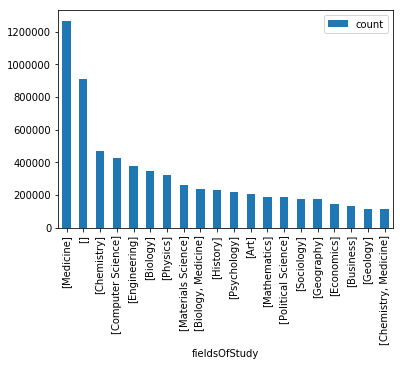

In [48]:
#convert Pyspark dataframe to Pandas dataframe for plotting
pdf = fields_count.toPandas()
pdf[:20].plot(kind= 'bar', x='fieldsOfStudy')
plt.show()

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api

inCitations_count_histogram = spark_df4.select('inCitations_count').rdd.flatMap(lambda x: x).histogram(11)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 85 in stage 29.0 failed 4 times, most recent failure: Lost task 85.3 in stage 29.0 (TID 1674, hd04.rcc.local, executor 317): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 342, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 80, in <lambda>
    return lambda *a: f(*a)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-15-0e6593b4a1c9>", line 4, in <lambda>
TypeError: object of type 'NoneType' has no len()

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:624)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:156)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:148)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:148)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:224)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:557)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:345)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1993)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:194)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1890)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2111)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2049)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:740)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2081)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2102)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2121)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2146)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 342, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 80, in <lambda>
    return lambda *a: f(*a)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-15-0e6593b4a1c9>", line 4, in <lambda>
TypeError: object of type 'NoneType' has no len()

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:624)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:156)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:148)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:148)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:224)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:557)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread$$anonfun$run$1.apply(PythonRunner.scala:345)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1993)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:194)


In [ ]:
# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*inCitations_count_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')

In [55]:
spark_df4.write.format('parquet').save('all_papers.parquet')

Py4JJavaError: An error occurred while calling o547.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:198)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:159)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:668)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:668)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:668)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:276)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:270)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:228)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 85 in stage 31.0 failed 4 times, most recent failure: Lost task 85.3 in stage 31.0 (TID 1852, hd03.rcc.local, executor 561): org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:257)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:170)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:169)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$11.apply(Executor.scala:407)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1408)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:413)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 342, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 80, in <lambda>
    return lambda *a: f(*a)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-15-0e6593b4a1c9>", line 4, in <lambda>
TypeError: object of type 'NoneType' has no len()

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:624)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:244)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:242)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1442)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:248)
	... 10 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1890)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:929)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:929)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2111)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2049)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:740)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2081)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:167)
	... 32 more
Caused by: org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:257)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:170)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:169)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$11.apply(Executor.scala:407)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1408)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:413)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 342, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/worker.py", line 80, in <lambda>
    return lambda *a: f(*a)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-15-0e6593b4a1c9>", line 4, in <lambda>
TypeError: object of type 'NoneType' has no len()

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$11$$anon$1.hasNext(WholeStageCodegenExec.scala:624)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:244)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:242)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1442)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:248)
	... 10 more


In [ ]:
!hdfs dfs -ls all_papers.csv

In [14]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)

In [15]:
#show databaes
spark.sql('show databases').show()

+-------------+
| databaseName|
+-------------+
|     aamorris|
|    ababikova|
|          abb|
|      abertin|
| abhishekchat|
|      achenad|
|  adeshghadge|
|      adetola|
| adhamsuliman|
|   aditilakra|
|       aghose|
|       ahphan|
|      airline|
|       alphan|
|       aluong|
|alvinharyanto|
|       amant3|
|    amiparikh|
|amoliterno945|
|     andmoral|
+-------------+
only showing top 20 rows

